In [1]:
import numpy as np
import pandas as pd
import os

import keras
import tensorflow as tf

from scipy import stats
from sklearn import metrics

from tqdm.notebook import tqdm
from typing import Sequence

from activations import ordinal_softmax
from datautils import load_customer_level_csv
from metrics import cumulative_true, gini_from_gain
from utils import dnn_split

from layers import CoralOrdinal
from loss import OrdinalCrossEntropy

## 1 - Read Data

In [2]:
CATEGORICAL_FEATURES = ['chain', 'dept', 'category', 'brand', 'productmeasure']
NUMERIC_FEATURES = ['log_calibration_value']
ALL_FEATURES = CATEGORICAL_FEATURES + NUMERIC_FEATURES

In [3]:
COMPANY = 10000
customer_level_data =  load_customer_level_csv(COMPANY)

In [4]:
customer_level_data.head(10)

,id,calibration_value,chain,dept,category,brand,productmeasure,holdout_value,log_calibration_value,label
0,86246,0.69,205,97,9753,0,CT,322.730011,-0.371064,322.730011
1,86252,4.69,205,0,0,0,UNKNOWN,310.040009,1.545433,310.040009
2,12262064,0.99,95,97,9753,0,CT,11.730000,-0.010050,11.730000
3,12277270,1.99,95,0,0,0,UNKNOWN,139.270004,0.688135,139.270004
4,12332190,1.00,95,97,9753,0,CT,11.720000,0.000000,11.720000
5,12524696,0.20,4,99,9908,33170,OZ,8.070000,-1.609438,8.070000
6,12682470,2.99,18,0,0,0,UNKNOWN,0.990000,1.095273,0.990000
7,12996040,1.99,15,0,0,0,UNKNOWN,49.509998,0.688135,49.509998
8,13074629,1.25,14,97,9753,0,CT,17.150000,0.223144,17.150000
9,13089312,2.00,15,97,9753,0,CT,30.240000,0.693147,30.240000


## 2 - Split label into pre-defined distributions

In [5]:
bins = [-0.001, 0.5, 1.0, 2, 5, 10, 25, 50, 100, 1000, 10000, 100_000, 2062412.0] # <- predefined buckets
keepbins = pd.cut(customer_level_data['label'], bins=bins, duplicates='drop').cat.categories.tolist()
print(len(keepbins))
customer_level_data['label_bucket'] = pd.cut(
    customer_level_data['label'],
    bins=bins,
    retbins = True,
    include_lowest = True,
    labels = range(len(keepbins)),
    duplicates='drop')[0].values

12


In [6]:
NUM_DISTRIBUTIONS = 4 # <- number of distributions
NUM_BUCKETS = len(keepbins) // NUM_DISTRIBUTIONS
dct_buckets = {i: i%NUM_BUCKETS for i in range(len(keepbins))}
dct_distributions = {i: i//NUM_BUCKETS for i in range(len(keepbins))}

In [7]:
dct_buckets

{0: 0, 1: 1, 2: 2, 3: 0, 4: 1, 5: 2, 6: 0, 7: 1, 8: 2, 9: 0, 10: 1, 11: 2}

In [8]:
dct_distributions

{0: 0, 1: 0, 2: 0, 3: 1, 4: 1, 5: 1, 6: 2, 7: 2, 8: 2, 9: 3, 10: 3, 11: 3}

In [9]:
# Replace the labels according to distributions and buckets

customer_level_data['label_distribution'] = customer_level_data['label_bucket']
customer_level_data["label_distribution"].replace(dct_distributions, inplace=True)
customer_level_data["label_bucket"].replace(dct_buckets, inplace=True)

## 3- Train-Test Split

In [10]:
# Min-Max scaling is performed inside the train/test split function. 
# Min-Max is performed separately for each distribution-bucket pair

## 4 - Layers


In [11]:
class SimpleDNN(tf.keras.layers.Layer):
    def __init__(self, num_bins = 3):

        super(SimpleDNN, self).__init__()
        self.num_bins = num_bins

        self.dropout1 = tf.keras.layers.Dropout(0.1)
        self.fc1 = tf.keras.layers.Dense(64, activation="relu")
        self.fc2 = tf.keras.layers.Dense(32, activation="relu")
        self.fc3 = tf.keras.layers.Dense(num_bins)
    
    def call(self, x):
        x = self.fc1(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        prob = self.fc3(x)
        return prob


In [12]:
class CoralDNN(tf.keras.layers.Layer):
    def __init__(self, num_bins = 3):

        super(CoralDNN, self).__init__()
        self.num_bins = num_bins

        self.fc1 = tf.keras.layers.Dense(64, activation="relu")
        self.dropout = tf.keras.layers.Dropout(0.1)
        self.fc2 = tf.keras.layers.Dense(32, activation="relu")
        self.coral = CoralOrdinal(num_bins)
    
    def call(self, x):
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        prob = self.coral(x)
        return prob


### 4-1 Distribution Segmentation Module (DSM)

In [13]:
class DSM(tf.keras.layers.Layer):

    def __init__(self, num_distributions=2):
        super(DSM, self).__init__()

        # predict distribution class
        self.dct = SimpleDNN(num_bins=num_distributions)
        
        # predict distribution ordinality
        self.dot = CoralDNN(num_bins=num_distributions)

    def call(self, x, training=True):
        dct = self.dct(x)
        dot = self.dot(x)
        return {
            'pred_dct': dct,
            'pred_dot': dot
        }     

### 4-2 Sub-Distribution modeling Module (SDM)


In [14]:
class SDM(tf.keras.layers.Layer):
    def __init__(self, num_buckets=2):

        super(SDM, self).__init__()
        # predict bucket class
        self.bct = SimpleDNN(num_bins=num_buckets)
        
        # predict bucket ordinality
#         self.bot = SimpleDNN(num_bins=num_buckets)
        self.bot = CoralDNN(num_bins=num_buckets)

        # predict minmax scaled label
        self.deep_model = tf.keras.Sequential([tf.keras.layers.Dense(32, activation="relu"),
                                               tf.keras.layers.Dense(num_buckets, activation='sigmoid')])

    def call(self, x, training=True):
        bct = self.bct(x)
        bot = self.bot(x)
        y_pred = self.deep_model(x, training=training)
        return {
            'pred_bct': bct,
            'pred_bot': bot,
            'pred_label': y_pred
        }

## 4-3 Multi Distribution Multi Experts Module (MDME)

In [15]:
class MDME(tf.keras.Model):
    def __init__(self, ltvmodel, *args, **kwargs):

        super().__init__()
        self.ltvmodel = ltvmodel
        self.loss_tracker = tf.keras.metrics.Mean(name="loss")
    
    def compile(self, optimizer, loss_fn):
        super().compile(optimizer)
        self.optimizer = optimizer
        self.loss_fn = loss_fn
    
    def call(self, x, training=False):
        return self.ltvmodel(x, training=training)
    
    def predict(self, x, training=False):
        y = self(x, training=training)
        return y

    @property
    def metrics(self):
        # We list our `Metric` objects here so that `reset_states()` can be
        # called automatically at the start of each epoch
        # or at the start of `evaluate()`.
        # If you don't implement this property, you have to call
        # `reset_states()` yourself at the time of your choosing.
        return [self.loss_tracker]
    
    def train_step(self, data):
        x, y = data
        with tf.GradientTape() as tape:
            y_pred = self(x, training=True)
            loss_value = self.loss_fn(y, y_pred)
        grads = tape.gradient(loss_value, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        self.loss_tracker.update_state(loss_value)
        return {"loss": self.loss_tracker.result()}
    
    def test_step(self, data):
        x, y = data
        y_pred = self(x, training=False)
        loss_value = self.loss_fn(y, y_pred)
        
        self.loss_tracker.update_state(loss_value)
        # Return a dict mapping metric names to current value.
        # Note that it will include the loss (tracked in self.metrics).
        return {"loss_val": self.loss_tracker.result()}

## 4-4 Defining loss 

In [16]:
class MDMELoss(tf.keras.losses.Loss):

    # initialize instance attributes
    def __init__(self):
        super(MDMELoss, self).__init__()
        
    # Compute loss
    def call(self, y_true, y_pred):
        
        losses = []
        
        y_true_dct = y_true['label_distribution']
        y_true_dot = y_true['label_ordinality']
        y_true_bucket_bct = y_true['bucket_distribution']
        y_true_bucket_bot = y_true['bucket_ordinality']
        y_true_bucket_label_minmax = y_true['label_minmax']
        
        y_pred_dct = y_pred['dsm']['pred_dct']        
        y_pred_dot = y_pred['dsm']['pred_dot'] 
        
        y_pred_bcts = []
        y_pred_bots = []
        y_pred_labels = []

        for i in range(NUM_DISTRIBUTIONS):
            y_pred_bcts.append(y_pred[f"sdm_{i}"]['pred_bct'])
            y_pred_bots.append(y_pred[f"sdm_{i}"]['pred_bot'])
            y_pred_labels.append(y_pred[f"sdm_{i}"]['pred_label'])
        y_pred_bcts = tf.stack(y_pred_bcts, axis=1)
        y_pred_bots = tf.stack(y_pred_bots, axis=1)
        y_pred_labels = tf.stack(y_pred_labels, axis=1)
        

        predicted_distribution_label = tf.argmax(y_pred_dct, axis=1)
        y_pred_bct = tf.gather(y_pred_bcts, predicted_distribution_label, batch_dims=1)
        y_pred_bot = tf.gather(y_pred_bots, predicted_distribution_label, batch_dims=1)
        y_pred_label = tf.gather(y_pred_labels, predicted_distribution_label, batch_dims=1)

        # Distribution classification loss
        loss_dct = tf.keras.losses.SparseCategoricalCrossentropy(
            from_logits=True, reduction='sum_over_batch_size')(y_true_dct, y_pred_dct)
        losses.append(loss_dct)

        # Distribution ordinal regression loss
        loss_dot = OrdinalCrossEntropy(NUM_DISTRIBUTIONS, reduction='sum_over_batch_size')(y_true_dot, y_pred_dot)
        losses.append(loss_dot)

        T = 0.1
        soft_teacher = ordinal_softmax(y_pred_dot / T)  # Teacher soft labels
        soft_student = tf.nn.softmax(y_pred_dct / T)  # Teacher soft labels
        loss_soft_labels = tf.keras.losses.KLDivergence(reduction='sum_over_batch_size')(tf.stop_gradient(soft_teacher), soft_student)
#         loss_soft_labels = tf.keras.losses.CategoricalCrossentropy(
#             from_logits=False,
#             reduction='sum_over_batch_size')(tf.stop_gradient(soft_teacher), soft_student)
        losses.append(0.5*loss_soft_labels)

        # Bucket classification loss
        loss_bucket_bct = tf.keras.losses.SparseCategoricalCrossentropy(
            from_logits=True, 
            reduction='sum_over_batch_size')(y_true_bucket_bct, y_pred_bct)
        losses.append(loss_bucket_bct)

        # Bucket ordinal regression loss
        loss_bucket_bot = OrdinalCrossEntropy(NUM_BUCKETS, reduction='sum_over_batch_size')(y_true_bucket_bot, y_pred_bot)
        losses.append(loss_bucket_bot)

        # Soft label loss
        T = 0.1
        soft_teacher = ordinal_softmax(y_pred_bot / T)  # Teacher soft labels
        soft_student = tf.nn.softmax(y_pred_bct / T)  # Teacher soft labels
        loss_soft_labels_bucket = tf.keras.losses.KLDivergence(
            reduction='sum_over_batch_size')(tf.stop_gradient(soft_teacher), soft_student)
#         loss_soft_labels_bucket = tf.keras.losses.CategoricalCrossentropy(
#             from_logits=False,
#             reduction='sum_over_batch_size')(tf.stop_gradient(soft_teacher), soft_student)
        losses.append(0.5*loss_soft_labels_bucket)

        # MSE Loss
        predicted_bucket_label = tf.argmax(y_pred_bct, axis=-1)
        y_pred_labels = tf.gather(y_pred_label, predicted_bucket_label, batch_dims=1)
        loss_mse = tf.keras.losses.MeanSquaredError(
            reduction='sum_over_batch_size')(y_true_bucket_label_minmax, y_pred_labels)
        losses.append(loss_mse)

        return tf.reduce_sum(losses)

## 5 - Building Input

In [17]:
def embedding_dim(x):
    return int(x**.25) + 1

def embedding_layer(vocab_size):
    return tf.keras.Sequential([
        tf.keras.layers.Embedding(input_dim=vocab_size,
#                                   output_dim=embedding_dim(vocab_size),
                                  output_dim = 5,
                                  input_length=1),
        tf.keras.layers.Flatten(),
    ])

In [18]:
numeric_input = tf.keras.layers.Input(shape=(len(NUMERIC_FEATURES),), name='numeric')
embedding_inputs = [
    tf.keras.layers.Input(shape=(1,), name=key, dtype=np.int64)
    for key in CATEGORICAL_FEATURES
]
embedding_outputs = [
    embedding_layer(vocab_size=customer_level_data[key].nunique())(input)
    for key, input in zip(CATEGORICAL_FEATURES, embedding_inputs)
]
deep_input = tf.keras.layers.concatenate([numeric_input] + embedding_outputs)

dsm_m = DSM(num_distributions=NUM_DISTRIBUTIONS)

outputs = {}
for i in range(NUM_DISTRIBUTIONS):
    sdm = SDM(num_buckets=NUM_BUCKETS)
    outputs[f"sdm_{i}"] = sdm(deep_input)
        

outputs['dsm'] = dsm_m(deep_input) 

ltvmodel = tf.keras.Model(inputs=[numeric_input] + embedding_inputs, outputs=outputs)

In [19]:
LEARNING_RATE = 1e-3
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss_val', min_lr=1e-6),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss_val', patience=10),
]
loss = MDMELoss()
model = MDME(ltvmodel)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE), loss_fn=loss)
print(f"Initial Learning Rate: {model.optimizer.lr.numpy()}")

Initial Learning Rate: 0.0010000000474974513


In [20]:
x_train, x_eval, y_train, y_eval, y0_eval = dnn_split(customer_level_data)

In [21]:
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=1024,
    epochs=400,
    verbose=2,
    callbacks=callbacks,
    validation_data=(x_eval, y_eval)).history

Epoch 1/400
184/184 - 8s - loss: 5.8276 - val_loss_val: 5.5189 - lr: 0.0010 - 8s/epoch - 41ms/step
Epoch 2/400
184/184 - 2s - loss: 5.4451 - val_loss_val: 5.3192 - lr: 0.0010 - 2s/epoch - 13ms/step
Epoch 3/400
184/184 - 2s - loss: 5.2764 - val_loss_val: 5.1975 - lr: 0.0010 - 2s/epoch - 12ms/step
Epoch 4/400
184/184 - 2s - loss: 5.1480 - val_loss_val: 5.0769 - lr: 0.0010 - 2s/epoch - 12ms/step
Epoch 5/400
184/184 - 2s - loss: 5.0352 - val_loss_val: 4.9796 - lr: 0.0010 - 2s/epoch - 13ms/step
Epoch 6/400
184/184 - 2s - loss: 4.9484 - val_loss_val: 4.9154 - lr: 0.0010 - 2s/epoch - 13ms/step
Epoch 7/400
184/184 - 2s - loss: 4.8866 - val_loss_val: 4.8614 - lr: 0.0010 - 2s/epoch - 13ms/step
Epoch 8/400
184/184 - 2s - loss: 4.8360 - val_loss_val: 4.8195 - lr: 0.0010 - 2s/epoch - 12ms/step
Epoch 9/400
184/184 - 2s - loss: 4.7990 - val_loss_val: 4.7848 - lr: 0.0010 - 2s/epoch - 13ms/step
Epoch 10/400
184/184 - 2s - loss: 4.7660 - val_loss_val: 4.7566 - lr: 0.0010 - 2s/epoch - 12ms/step
Epoch 11/

<AxesSubplot:>

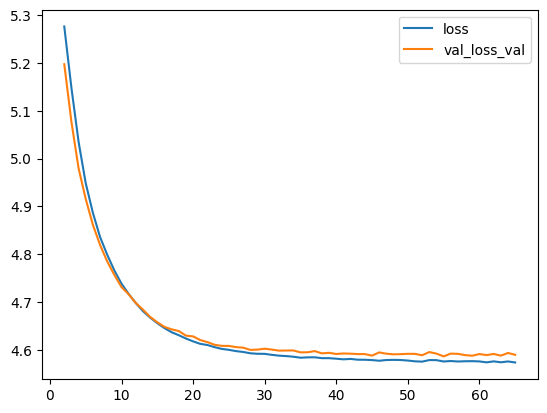

In [22]:
pd.DataFrame(history)[['loss', 'val_loss_val']][2:].plot()

## 6 - Inference

In [23]:
logits = model.predict(x=x_eval)
y_pred = []
for i in range(logits['dsm']['pred_dct'].shape[0]):
    item = logits['dsm']['pred_dct'][i]
    distribution_label = tf.math.argmax(item).numpy()
    bucket = logits[f"sdm_{distribution_label}"]['pred_bct'][i]
    sigmas = logits[f"sdm_{distribution_label}"]['pred_label'][i]
    bucket_label = tf.math.argmax(bucket).numpy()
    idx = distribution_label * NUM_BUCKETS + bucket_label
    pred = keepbins[idx].left + sigmas[bucket_label] * keepbins[idx].length
    y_pred.append(pred.numpy())

## 7 - Evaluation

In [24]:
df_pred = pd.DataFrame({
    'y_true': y_eval['label'],
    'y_pred': y_pred,
    'label_distribution': y_eval['label_distribution'],
    'bucket_distribution': y_eval['bucket_distribution'],
})
df_pred.head(10)

,y_true,y_pred,label_distribution,bucket_distribution
69003,31.400000,6.975223,2,0
87546,0.990000,70.562073,0,1
174617,0.990000,0.173319,0,1
181104,48.330002,6.867325,2,0
7254,1.300000,7.187225,0,2
229183,9.450000,6.961293,1,1
29027,20.750000,6.910069,1,2
135880,43.200001,7.004164,2,0
115346,15.000000,7.027415,1,2
153886,0.000000,6.984661,0,0


In [25]:
def spearmanr(x1: Sequence[float], x2: Sequence[float]) -> float:
  """Calculates spearmanr rank correlation coefficient.

  See https://docs.scipy.org/doc/scipy/reference/stats.html.

  Args:
    x1: 1D array_like.
    x2: 1D array_like.

  Returns:
    correlation: float.
  """
  return stats.spearmanr(x1, x2, nan_policy='raise')[0]


spearman_corr = spearmanr(df_pred['y_true'], df_pred['y_pred'])
print('Spearman correlation:', spearman_corr)

positive_index = df_pred['y_true'] > 0
spearman_corr_pos = spearmanr(df_pred.loc[positive_index, 'y_true'], df_pred.loc[positive_index, 'y_pred'])
print('Only positive samples spearman correlation:', spearman_corr_pos)

Spearman correlation: 0.1933827230662824
Only positive samples spearman correlation: 0.10927816691307894


In [26]:
gain = pd.DataFrame({
    'lorenz': cumulative_true(df_pred['y_true'], df_pred['y_true']),
    'baseline': cumulative_true(df_pred['y_true'], y0_eval),
    'model': cumulative_true(df_pred['y_true'], df_pred['y_pred']),
})
num_customers = np.float32(gain.shape[0])
gain['cumulative_customer'] = (np.arange(num_customers) + 1.) / num_customers

In [27]:
gini = gini_from_gain(gain[['lorenz', 'baseline', 'model']])
gini

,raw,normalized
lorenz,0.891897,1.000000
baseline,0.725321,0.813235
model,0.696189,0.780571


In [28]:
metrics.mean_absolute_error(df_pred['y_true'], df_pred['y_pred'])

60.906475